In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import json
import argparse

import torch
import numpy as np
from tensorboardX import SummaryWriter

from maml.datasets.simple_functions import (
    SinusoidMetaDataset,
    LinearMetaDataset,
    MixedFunctionsMetaDataset,
    ManyFunctionsMetaDataset,
    FiveFunctionsMetaDataset,
    MultiSinusoidsMetaDataset,
)
from maml.models.fully_connected import FullyConnectedModel, MultiFullyConnectedModel
from maml.models.gated_net import GatedNet
from maml.models.lstm_embedding_model import LSTMEmbeddingModel
from maml.metalearner import MetaLearner
from maml.trainer import Trainer
from maml.utils import optimizer_to_device, get_git_revision_hash

In [4]:
def str2bool(arg):
    return arg.lower() == 'true'

parser = argparse.ArgumentParser(
    description='Multimodal Model-Agnostic Meta-Learning (MAML)')

# Model
parser.add_argument('--hidden-sizes', type=int,
                    default=[256, 128, 64, 64], nargs='+',
                    help='number of hidden units per layer')
parser.add_argument('--model-type', type=str, default='fc',
                    help='type of the model')
parser.add_argument('--condition-type', type=str, default='affine',
                    help='type of the conditional layers')
parser.add_argument('--use-max-pool', action='store_true',
                    help='choose whether to use max pooling with convolutional model')
parser.add_argument('--num-channels', type=int, default=64,
                    help='number of channels in convolutional layers')
parser.add_argument('--disable-norm', action='store_true',
                    help='disable batchnorm after linear layers in a fully connected model')
parser.add_argument('--bias-transformation-size', type=int, default=0,
                    help='size of bias transformation vector that is concatenated with '
                    'input')
parser.add_argument('--condition-order', type=str, default='low2high',
                    help='order of the conditional layers to be used')

# Embedding
parser.add_argument('--embedding-type', type=str, default='',
                    help='type of the embedding')
parser.add_argument('--embedding-hidden-size', type=int, default=40,
                    help='number of hidden units per layer in recurrent embedding model')
parser.add_argument('--embedding-num-layers', type=int, default=2,
                    help='number of layers in recurrent embedding model')
parser.add_argument('--embedding-dims', type=int, nargs='+', default=0,
                    help='dimensions of the embeddings')

# Randomly sampled embedding vectors
parser.add_argument('--num-sample-embedding', type=int, default=0,
                    help='number of randomly sampled embedding vectors')
parser.add_argument(
    '--sample-embedding-file', type=str, default='embeddings',
    help='the file name of randomly sampled embedding vectors')
parser.add_argument(
    '--sample-embedding-file-type', type=str, default='hdf5')

# Inner loop
parser.add_argument('--first-order', action='store_true',
                    help='use the first-order approximation of MAML')
parser.add_argument('--fast-lr', type=float, default=0.4,
                    help='learning rate for the 1-step gradient update of MAML')
parser.add_argument('--inner-loop-grad-clip', type=float, default=0.0,
                    help='enable gradient clipping in the inner loop')
parser.add_argument('--num-updates', type=int, default=1,
                    help='how many update steps in the inner loop')

# Optimization
parser.add_argument('--num-batches', type=int, default=1920000,
                    help='number of batches')
parser.add_argument('--meta-batch-size', type=int, default=32,
                    help='number of tasks per batch')
parser.add_argument('--slow-lr', type=float, default=0.001,
                    help='learning rate for the global update of MAML')

# Miscellaneous
parser.add_argument('--output-folder', type=str, default='maml',
                    help='name of the output folder')
parser.add_argument('--device', type=str, default='cpu',
                    help='set the device (cpu or cuda)')
parser.add_argument('--num-workers', type=int, default=4,
                    help='how many DataLoader workers to use')
parser.add_argument('--log-interval', type=int, default=100,
                    help='number of batches between tensorboard writes')
parser.add_argument('--save-interval', type=int, default=1000,
                    help='number of batches between model saves')
parser.add_argument('--eval', action='store_true', default=False,
                    help='evaluate model')
parser.add_argument('--checkpoint', type=str, default='',
                    help='path to saved parameters.')

# Dataset
parser.add_argument('--dataset', type=str, default='omniglot',
                    help='which dataset to use')
parser.add_argument('--data-root', type=str, default='data',
                    help='path to store datasets')
parser.add_argument('--num-samples-per-class', type=int, default=1,
                    help='how many samples per class for training')
parser.add_argument('--num-val-samples', type=int, default=1,
                    help='how many samples per class for validation')
parser.add_argument('--input-range', type=float, default=[-5.0, 5.0],
                    nargs='+', help='input range of simple functions')
parser.add_argument('--phase-range', type=float, default=[0, np.pi],
                    nargs='+', help='phase range of sinusoids')
parser.add_argument('--amp-range', type=float, default=[0.1, 5.0],
                    nargs='+', help='amp range of sinusoids')
parser.add_argument('--slope-range', type=float, default=[-3.0, 3.0],
                    nargs='+', help='slope range of linear functions')
parser.add_argument('--intersect-range', type=float, default=[-3.0, 3.0],
                    nargs='+', help='intersect range of linear functions')
parser.add_argument('--noise-std', type=float, default=0.0,
                    help='add gaussian noise to mixed functions')
parser.add_argument('--oracle', action='store_true',
                    help='concatenate phase and amp to sinusoid inputs')
parser.add_argument('--task-oracle', action='store_true',
                    help='uses task id for prediction in some models')

parser.add_argument('--embedding-grad-clip', type=float, default=2.0,
                    help='')
parser.add_argument('--model-grad-clip', type=float, default=2.0,
                    help='')

args = parser.parse_args([])

if args.embedding_dims == 0:
    args.embedding_dims = args.hidden_sizes
    
# Create logs and saves folder if they don't exist
if not os.path.exists('./train_dir'):
    os.makedirs('./train_dir')

# Make sure num sample embedding < num sample tasks
args.num_sample_embedding = min(
    args.num_sample_embedding, args.num_batches)

# Device
args.device = torch.device(
    args.device if torch.cuda.is_available() else 'cpu')
    
is_training = not args.eval
run_name = 'train' if is_training else 'eval'

if is_training:
    writer = SummaryWriter('./train_dir/{0}/{1}'.format(
        args.output_folder, run_name))
else:
    writer = None

save_folder = './train_dir/{0}'.format(args.output_folder)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

config_name = '{0}_config.json'.format(run_name)
with open(os.path.join(save_folder, config_name), 'w') as f:
    config = {k: v for (k, v) in vars(args).items() if k != 'device'}
    config.update(device=args.device.type)
    config.update({'git_hash': get_git_revision_hash()})
    json.dump(config, f, indent=2)

In [5]:
args

Namespace(amp_range=[0.1, 5.0], bias_transformation_size=0, checkpoint='', condition_order='low2high', condition_type='affine', data_root='data', dataset='omniglot', device=device(type='cpu'), disable_norm=False, embedding_dims=[256, 128, 64, 64], embedding_grad_clip=2.0, embedding_hidden_size=40, embedding_num_layers=2, embedding_type='', eval=False, fast_lr=0.4, first_order=False, hidden_sizes=[256, 128, 64, 64], inner_loop_grad_clip=0.0, input_range=[-5.0, 5.0], intersect_range=[-3.0, 3.0], log_interval=100, meta_batch_size=32, model_grad_clip=2.0, model_type='fc', noise_std=0.0, num_batches=1920000, num_channels=64, num_sample_embedding=0, num_samples_per_class=1, num_updates=1, num_val_samples=1, num_workers=4, oracle=False, output_folder='maml', phase_range=[0, 3.141592653589793], sample_embedding_file='embeddings', sample_embedding_file_type='hdf5', save_interval=1000, slope_range=[-3.0, 3.0], slow_lr=0.001, task_oracle=False, use_max_pool=False)

In [6]:
args.dataset

'omniglot'

In [7]:
_num_tasks = 1

In [8]:
args.dataset = 'linear'

In [9]:
dataset = LinearMetaDataset(
    num_total_batches=args.num_batches,
    num_samples_per_function=args.num_samples_per_class,
    num_val_samples=args.num_val_samples,
    meta_batch_size=args.meta_batch_size,
    slope_range=args.slope_range,
    intersect_range=args.intersect_range,
    input_range=[-1.0, 1.0], #args.input_range,
    oracle=args.oracle,
    train=is_training,
    device=args.device)
loss_func = torch.nn.MSELoss()
collect_accuracies = False

In [10]:
dataset.__dict__

{'_num_total_batches': 1920000,
 '_num_samples_per_function': 1,
 '_num_val_samples': 1,
 '_num_total_samples': 1,
 '_meta_batch_size': 32,
 '_oracle': False,
 '_train': True,
 '_device': device(type='cpu'),
 '_dtype': torch.float32,
 '_slope_range': [-3.0, 3.0],
 '_intersect_range': [-3.0, 3.0],
 '_input_range': [-1.0, 1.0],
 'input_size': 1,
 'output_size': 1}

In [11]:
def get_linear_points(tasks):
    xs, ys, slopes, intersects = [], [], [], []
    for task in tasks:
        xs.append(task.x.numpy())
        ys.append(task.y.numpy())
        slopes.append(task.task_info['slope'])
        intersects.append(task.task_info['intersect'])
        
    return np.array(xs), np.array(ys), np.array(slopes), np.array(intersects)

In [12]:
for i, (train, val) in enumerate(iter(dataset)):
    print(train)
    if i == 10:
        break

[Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': 1.1976959957980036, 'intersect': -2.491124634615182}), Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': 1.91290745332988, 'intersect': -2.5612186399414214}), Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': 0.788660328505224, 'intersect': -2.0273379804674496}), Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': 2.895365033973116, 'intersect': 1.9799833253366783}), Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': 0.9467803170368709, 'intersect': 1.7272816117797207}), Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': -2.6781086374421696, 'intersect': 0.927880956156069}), Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': 1.3405815960025684, 'intersect': 1.5403287851803142}), Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': 2.861203345297201, 'intersect': -2.250377961611182}), Task(x=tensor([]), y=tenso

In [13]:
train_tasks, val_tasks = next(iter(dataset))

In [14]:
train_tasks

[Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': -2.1641197387508613, 'intersect': -2.202517566286094}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': -1.9971874083376244, 'intersect': 2.5493657375460526}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': 0.5075432979418562, 'intersect': -0.4538872619609631}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': -1.0406690352608645, 'intersect': -2.3477132695775906}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': -0.519949519441635, 'intersect': -2.488441225382416}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': -0.59305577518258, 'intersect': 0.7090767696176989}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': -2.3265836714090855, 'intersect': 1.0038292573896435}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'slope': -1.0844456222567855, 'intersect': -2.4276807407598495}),
 Task(x=t

In [15]:
xs, ys, slopes, intersects = get_linear_points(train_tasks)
xs, ys, slopes, intersects

(array([], shape=(32, 0), dtype=float32),
 array([], shape=(32, 0), dtype=float32),
 array([-2.16411974, -1.99718741,  0.5075433 , -1.04066904, -0.51994952,
        -0.59305578, -2.32658367, -1.08444562,  1.4064278 , -2.16803187,
         2.38922003, -1.77185106, -1.22557006, -2.3197053 , -2.61078736,
        -0.78579727,  2.1563851 ,  1.40994122, -0.21079908,  1.92958014,
        -0.21868918, -0.58014773, -0.91932017,  0.5862905 ,  2.86932521,
        -0.50354725, -0.63769624, -2.22388685, -1.39983953, -2.42312803,
        -2.01240287,  0.04176962]),
 array([-2.20251757,  2.54936574, -0.45388726, -2.34771327, -2.48844123,
         0.70907677,  1.00382926, -2.42768074, -0.80668962, -0.74448074,
         0.30834296,  0.64204265,  2.78782467,  2.4656021 , -2.93390492,
        -1.56247537,  1.5817055 , -1.85877217, -2.96093683, -2.90806198,
        -2.25344587,  1.13304865, -1.41576665, -2.46828685, -0.62204875,
         2.88707869, -1.38110042,  2.05906298, -0.43948754,  2.45835437,
    

In [16]:
xs, ys, slopes, intersects = get_linear_points(val_tasks)
xs, ys, slopes, intersects

(array([[[-0.31368205]],
 
        [[ 0.6091487 ]],
 
        [[-0.81151444]],
 
        [[-0.26391652]],
 
        [[ 0.46506158]],
 
        [[-0.10172495]],
 
        [[-0.26496273]],
 
        [[ 0.7800533 ]],
 
        [[ 0.2103563 ]],
 
        [[ 0.73523253]],
 
        [[ 0.38625622]],
 
        [[-0.36203533]],
 
        [[-0.3063234 ]],
 
        [[-0.5251639 ]],
 
        [[ 0.00333853]],
 
        [[ 0.30281642]],
 
        [[-0.5173424 ]],
 
        [[ 0.66764355]],
 
        [[ 0.80384135]],
 
        [[-0.30269518]],
 
        [[ 0.82259697]],
 
        [[ 0.84261787]],
 
        [[ 0.98775417]],
 
        [[-0.945405  ]],
 
        [[-0.4264514 ]],
 
        [[-0.15215573]],
 
        [[ 0.9838487 ]],
 
        [[ 0.2608671 ]],
 
        [[ 0.28756753]],
 
        [[ 0.741021  ]],
 
        [[ 0.7767499 ]],
 
        [[-0.638196  ]]], dtype=float32),
 array([[[-1.5236721 ]],
 
        [[ 1.3327817 ]],
 
        [[-0.865766  ]],
 
        [[-2.0730636 ]],
 
        [[-2.

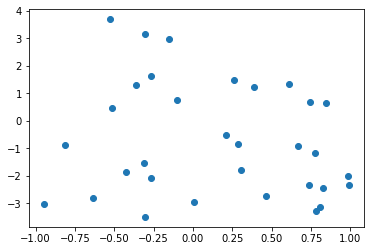

In [17]:
plt.scatter(xs, ys)

---

In [18]:
args.dataset = 'sinusoid'

In [19]:
dataset = SinusoidMetaDataset(
    num_total_batches=args.num_batches,
    num_samples_per_function=args.num_samples_per_class,
    num_val_samples=args.num_val_samples,
    meta_batch_size=args.meta_batch_size,
    amp_range=args.amp_range,
    phase_range=args.phase_range,
    input_range=args.input_range,
    oracle=args.oracle,
    train=is_training,
    device=args.device)
loss_func = torch.nn.MSELoss()
collect_accuracies = False

In [20]:
dataset.__dict__

{'_num_total_batches': 1920000,
 '_num_samples_per_function': 1,
 '_num_val_samples': 1,
 '_num_total_samples': 1,
 '_meta_batch_size': 32,
 '_oracle': False,
 '_train': True,
 '_device': device(type='cpu'),
 '_dtype': torch.float32,
 '_amp_range': [0.1, 5.0],
 '_phase_range': [0, 3.141592653589793],
 '_input_range': [-5.0, 5.0],
 'input_size': 1,
 'output_size': 1}

In [21]:
train_tasks, val_tasks = next(iter(dataset))

In [22]:
train_tasks

[Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 1.6071328468670443, 'phase': 1.0753211869428392}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 0.12414020256253733, 'phase': 1.3914196389030475}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 3.886190851079205, 'phase': 2.67195459671902}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 1.6381043954443701, 'phase': 1.926271790665856}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 1.6898826245403817, 'phase': 2.365504959118674}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 4.487247775075262, 'phase': 0.24635851841054726}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 3.070990432414165, 'phase': 0.9783870937368967}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 1.6827430021410519, 'phase': 0.7817109386482568}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 1.7

In [23]:
def get_sinusoid_points(tasks):
    xs, ys, amps, phases = [], [], [], []
    for task in tasks:
        xs.append(task.x.numpy())
        ys.append(task.y.numpy())
        amps.append(task.task_info['amp'])
        phases.append(task.task_info['phase'])
        
    return np.array(xs), np.array(ys), np.array(amps), np.array(phases)

In [24]:
train_tasks

[Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 1.6071328468670443, 'phase': 1.0753211869428392}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 0.12414020256253733, 'phase': 1.3914196389030475}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 3.886190851079205, 'phase': 2.67195459671902}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 1.6381043954443701, 'phase': 1.926271790665856}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 1.6898826245403817, 'phase': 2.365504959118674}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 4.487247775075262, 'phase': 0.24635851841054726}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 3.070990432414165, 'phase': 0.9783870937368967}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 1.6827430021410519, 'phase': 0.7817109386482568}),
 Task(x=tensor([]), y=tensor([]), task_info={'task_id': 0, 'amp': 1.7

In [25]:
xs, ys, amps, phases = get_sinusoid_points(train_tasks)
xs, ys, amps, phases

(array([], shape=(32, 0), dtype=float32),
 array([], shape=(32, 0), dtype=float32),
 array([1.60713285, 0.1241402 , 3.88619085, 1.6381044 , 1.68988262,
        4.48724778, 3.07099043, 1.682743  , 1.71248686, 3.64066843,
        1.71286635, 1.04765315, 3.10998666, 3.68644793, 2.10102153,
        4.29718548, 4.93442603, 2.21382596, 1.8021006 , 4.29462082,
        4.78156215, 2.09985703, 2.40122828, 3.90843672, 2.50100711,
        3.80685482, 0.99198476, 4.13451955, 3.64356543, 0.79977167,
        1.75649235, 1.20444462]),
 array([1.07532119, 1.39141964, 2.6719546 , 1.92627179, 2.36550496,
        0.24635852, 0.97838709, 0.78171094, 0.06110662, 3.07357556,
        2.76433009, 2.47859912, 1.70636853, 2.12091375, 1.69178327,
        1.44330221, 2.41571035, 0.05315851, 1.39855672, 1.17320959,
        1.27312973, 1.78667083, 0.11535852, 0.17281483, 2.70508729,
        0.03321716, 2.56470914, 2.86554642, 2.04589888, 1.6989439 ,
        0.92303453, 2.56598225]))

In [26]:
val_tasks

[Task(x=tensor([[3.2284]]), y=tensor([[1.3423]]), task_info={'task_id': 0, 'amp': 1.6071328468670443, 'phase': 1.0753211869428392}),
 Task(x=tensor([[0.6644]]), y=tensor([[-0.0825]]), task_info={'task_id': 0, 'amp': 0.12414020256253733, 'phase': 1.3914196389030475}),
 Task(x=tensor([[-4.6574]]), y=tensor([[-3.3635]]), task_info={'task_id': 0, 'amp': 3.886190851079205, 'phase': 2.67195459671902}),
 Task(x=tensor([[-2.1331]]), y=tensor([[1.3010]]), task_info={'task_id': 0, 'amp': 1.6381043954443701, 'phase': 1.926271790665856}),
 Task(x=tensor([[0.3057]]), y=tensor([[-1.4918]]), task_info={'task_id': 0, 'amp': 1.6898826245403817, 'phase': 2.365504959118674}),
 Task(x=tensor([[1.4750]]), y=tensor([[4.2272]]), task_info={'task_id': 0, 'amp': 4.487247775075262, 'phase': 0.24635851841054726}),
 Task(x=tensor([[3.8482]]), y=tensor([[0.8244]]), task_info={'task_id': 0, 'amp': 3.070990432414165, 'phase': 0.9783870937368967}),
 Task(x=tensor([[-2.7504]]), y=tensor([[0.6405]]), task_info={'task_i

In [27]:
xs, ys, amps, phases = get_sinusoid_points(val_tasks)
xs, ys, amps, phases

(array([[[ 3.228362  ]],
 
        [[ 0.6643756 ]],
 
        [[-4.6573997 ]],
 
        [[-2.1330621 ]],
 
        [[ 0.30570912]],
 
        [[ 1.4750475 ]],
 
        [[ 3.8482096 ]],
 
        [[-2.750359  ]],
 
        [[ 0.42096   ]],
 
        [[-0.6430575 ]],
 
        [[-3.8944783 ]],
 
        [[ 2.959131  ]],
 
        [[ 2.9497688 ]],
 
        [[-1.64882   ]],
 
        [[ 3.629678  ]],
 
        [[-2.449813  ]],
 
        [[-0.96870553]],
 
        [[ 3.7239735 ]],
 
        [[-4.0707464 ]],
 
        [[-2.4518285 ]],
 
        [[-3.5041697 ]],
 
        [[-4.045134  ]],
 
        [[-2.26257   ]],
 
        [[-4.2978334 ]],
 
        [[ 3.0684392 ]],
 
        [[ 1.7817893 ]],
 
        [[ 1.9593512 ]],
 
        [[-0.75853574]],
 
        [[-4.940924  ]],
 
        [[-2.4881818 ]],
 
        [[-1.9416338 ]],
 
        [[ 1.3758627 ]]], dtype=float32),
 array([[[ 1.3423263 ]],
 
        [[-0.08251153]],
 
        [[-3.3635397 ]],
 
        [[ 1.3010336 ]],
 
        [[-1.